# What is this notebook about
This notebook will truncate the train_all and test_all data generated from the notebook `3_train_test_set.ipynb` into a smaller dataset. This is so that we can fit our training data into the SCSE GPU Cluster.

> Please ensure you have run the notebook `3_train_test_set.ipynb` before this

> Total train-test size now: 10.3GB

> Target train-test size: 5GB (half)

# Setup and Imports

In [9]:
import os
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm 
from PIL import Image 
from shutil import copyfile

# Global Variables

In [10]:
ROOT_DIR = Path('')
PATH_DATA_ALL = ROOT_DIR/'data_all/AOI_11_Rotterdam'

In [11]:
# An index, used just for inspecting one specific file
INSPECT_IDX = 0

# Set seed for repeatable results
seed = 42
np.random.seed(seed)
# tf.random.set_seed(seed)

# Image specifications
IMG_HEIGHT, IMG_WIDTH = 224, 224

# Helper Functions

### plot_img_mask(img, mask, index)
To plot an image and a mask (traditional RGB) side by side

In [12]:
def plot_img_mask(img, mask, index):    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
    ax1.imshow(img)
    ax2.imshow(mask)
    
    print("Index: {}".format(index))
    plt.show()        

### get_fnames(path)
To return a list of sorted filenames in a given path

In [13]:
def get_fnames(path):
    fnames = next(os.walk(path))[2]
    fnames.sort()
    return fnames

### rebuild_npy(npy_path, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)
Recreates a .npy image file from global height and width variables. Returns a np array

In [31]:
def rebuild_npy(npy_path, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    img_npy = np.load(npy_path)
    img_channel = int(len(img_npy)/img_height/img_width)
    
    if img_channel == 1:
        return img_npy.reshape(img_height,img_width)
    elif img_channel == 3:
        return img_npy.reshape(img_height,img_width, img_channel)
    else:
        print("cannot rebuild")
        return 

# Taking half of the train_all and test_all

### Grab the necessary files
We will be splitting the PS-RGB images and masks as a pair

In [15]:
PATH_TRAIN_ALL = PATH_DATA_ALL/'train_all'
PATH_TEST_ALL = PATH_DATA_ALL/'test_all'

PATH_TRAIN_ALL_IMG = PATH_TRAIN_ALL/'img'
PATH_TRAIN_ALL_MASK = PATH_TRAIN_ALL/'mask'
PATH_TEST_ALL_IMG = PATH_TEST_ALL/'img'
PATH_TEST_ALL_MASK = PATH_TEST_ALL/'mask'

fnames_train_all_img = get_fnames(PATH_TRAIN_ALL_IMG)
fnames_train_all_mask = get_fnames(PATH_TRAIN_ALL_MASK)
fnames_test_all_img = get_fnames(PATH_TEST_ALL_IMG)
fnames_test_all_mask = get_fnames(PATH_TEST_ALL_MASK)

### Set the output directories

In [16]:
PATH_DATA_PROJECT = ROOT_DIR/'data_project'

PATH_TRAIN = PATH_DATA_PROJECT/'train'
PATH_TEST = PATH_DATA_PROJECT/'test'

PATH_TRAIN_IMG = PATH_TRAIN/'img'
PATH_TRAIN_MASK = PATH_TRAIN/'mask'
PATH_TEST_IMG = PATH_TEST/'img'
PATH_TEST_MASK = PATH_TEST/'mask'

for path in [PATH_DATA_PROJECT, PATH_TRAIN, PATH_TEST, PATH_TRAIN_IMG, PATH_TRAIN_MASK, PATH_TEST_IMG, PATH_TEST_MASK]:
    if not os.path.exists(path):
        os.makedirs(path)

### Generate half the indexes

In [17]:
 # set the various sizes we want to use 
SIZE_TRAIN_ALL = len(fnames_train_all_img)
SIZE_TEST_ALL = len(fnames_test_all_img)
SIZE_TRAIN = int(SIZE_TRAIN_ALL/2) # about half of original        
SIZE_TEST = int(SIZE_TEST_ALL/2) # about half of original  


# Load the TRAIN_IDX_ALL.npy and TEST_IDX_ALL.npy 
TRAIN_ALL_IDX = np.load(PATH_TRAIN_ALL/('TRAIN_ALL_IDX_'+str(SIZE_TRAIN_ALL)+'.npy'))
TEST_ALL_IDX = np.load(PATH_TEST_ALL/('TEST_ALL_IDX_'+str(SIZE_TEST_ALL)+'.npy'))

print("TRAIN_ALL/TEST_ALL indexes loaded")
print("TRAIN_ALL_IDX:", PATH_TRAIN_ALL/('TRAIN_ALL_IDX_'+str(SIZE_TRAIN_ALL)+'.npy'))
print("TEST_ALL_IDX:", PATH_TEST_ALL/('TEST_ALL_IDX_'+str(SIZE_TEST_ALL)+'.npy'))

TRAIN_ALL/TEST_ALL indexes loaded
TRAIN_ALL_IDX: data_all\AOI_11_Rotterdam\train_all\TRAIN_ALL_IDX_38091.npy
TEST_ALL_IDX: data_all\AOI_11_Rotterdam\test_all\TEST_ALL_IDX_16325.npy


In [18]:
# Generate the indexes that we will be using for train and test 
TRAIN_IDX = np.random.choice(TRAIN_ALL_IDX, SIZE_TRAIN, replace=False)
TRAIN_IDX.sort()

TEST_IDX = np.random.choice(TEST_ALL_IDX, SIZE_TEST, replace=False)
TEST_IDX.sort()


# Save the indexes
np.save(PATH_TRAIN/('TRAIN_IDX_'+str(SIZE_TRAIN)), TRAIN_IDX)
np.save(PATH_TEST/('TEST_IDX_'+str(SIZE_TEST)), TEST_IDX)
print('Generating and saving TRAIN/TEST indexes')


# Load it back out
TRAIN_IDX = np.load(PATH_TRAIN/('TRAIN_IDX_'+str(SIZE_TRAIN)+'.npy'))
TEST_IDX = np.load(PATH_TEST/('TEST_IDX_'+str(SIZE_TEST)+'.npy'))

print("TRAIN/TEST indexes loaded")
print("TRAIN_IDX:", PATH_TRAIN/('TRAIN_IDX_'+str(SIZE_TRAIN)+'.npy'))
print("TEST_IDX:", PATH_TEST/('TEST_IDX_'+str(SIZE_TEST)+'.npy'))

Generating and saving TRAIN/TEST indexes
TRAIN/TEST indexes loaded
TRAIN_IDX: data_project\train\TRAIN_IDX_19045.npy
TEST_IDX: data_project\test\TEST_IDX_8162.npy


### Copy the half that we want into data_project
We will copy from tile_img and tile_mask

In [19]:
# Bring in tile_img and tile_mask filenames
PATH_TILE_IMG = PATH_DATA_ALL/'tile_img'
PATH_TILE_MASK = PATH_DATA_ALL/'tile_mask'

fnames_tile_img = get_fnames(PATH_TILE_IMG)
fnames_tile_mask = get_fnames(PATH_TILE_MASK)

In [20]:
for index in tqdm(TRAIN_IDX, total=len(TRAIN_IDX)):
    fname_img = fnames_tile_img[index].split('.')[0] + '.npy'
    fname_mask = fnames_tile_mask[index].split('.')[0] + '.npy'
    copyfile(PATH_TRAIN_ALL_IMG/fname_img, PATH_TRAIN_IMG/fname_img)
    copyfile(PATH_TRAIN_ALL_MASK/fname_mask, PATH_TRAIN_MASK/fname_mask)
print("TRAIN data copied")
    
for index in tqdm(TEST_IDX, total=len(TEST_IDX)):
    fname_img = fnames_tile_img[index].split('.')[0] + '.npy'
    fname_mask = fnames_tile_mask[index].split('.')[0] + '.npy'
    copyfile(PATH_TEST_ALL_IMG/fname_img, PATH_TEST_IMG/fname_img)
    copyfile(PATH_TEST_ALL_MASK/fname_mask, PATH_TEST_MASK/fname_mask)
print("TEST data copied")

  0%|                                                                                 | 8/8162 [00:00<01:48, 74.97it/s]

TRAIN data copied


100%|██████████████████████████████████████████████████████████████████████████████| 8162/8162 [02:03<00:00, 66.23it/s]

TEST data copied


### Inspect our TRAIN/TEST data

Index: 15204


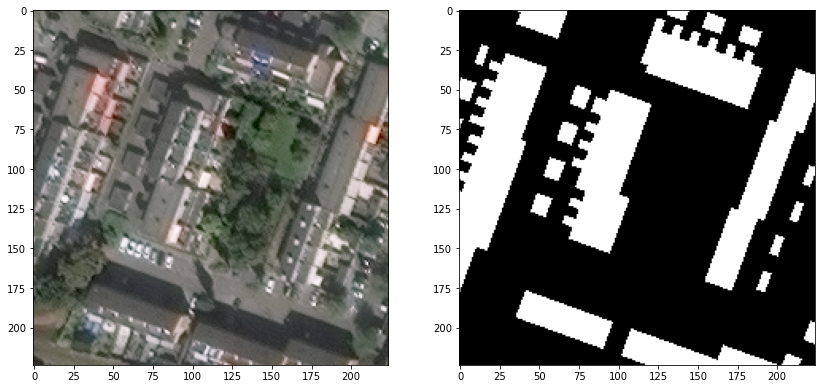

Index: 13442


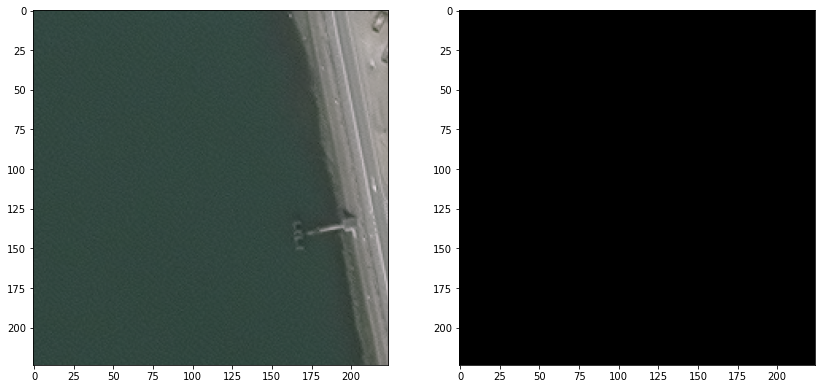

Index: 4266


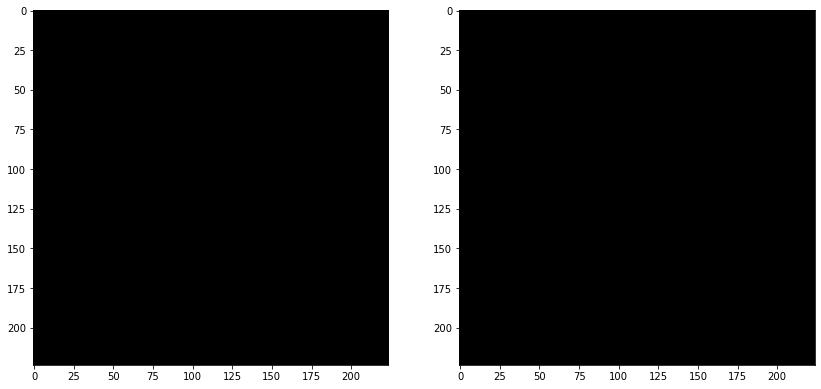

Index: 9545


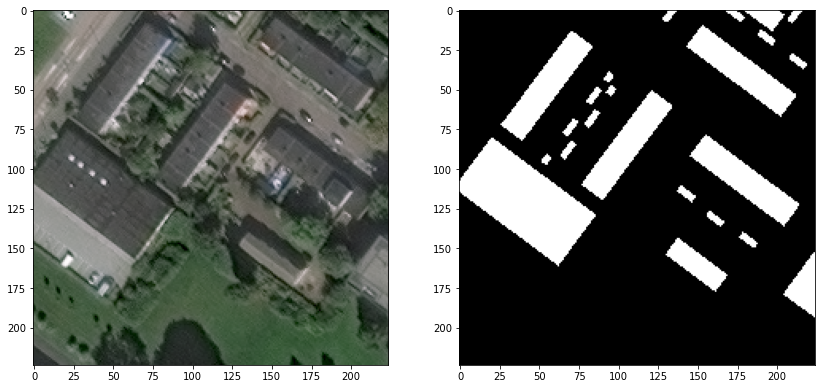

In [34]:
fnames_train_img = get_fnames(PATH_TRAIN_IMG)
fnames_train_mask = get_fnames(PATH_TRAIN_MASK)

for i in range(4):
    index = np.random.randint(0, len(fnames_train_img))
    sample_img = rebuild_npy(PATH_TRAIN_IMG/fnames_train_img[index])
    sample_mask = rebuild_npy(PATH_TRAIN_MASK/fnames_train_mask[index])
    
    sample_img = Image.fromarray(sample_img)
    sample_mask = Image.fromarray(sample_mask)
    plot_img_mask(sample_img, sample_mask, index)

Index: 4130


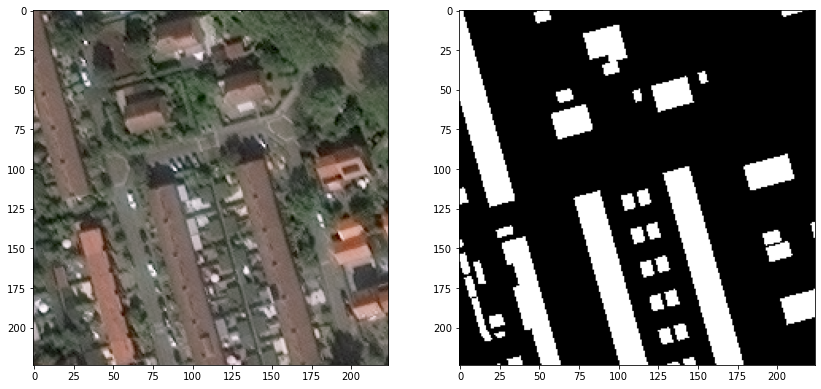

Index: 1224


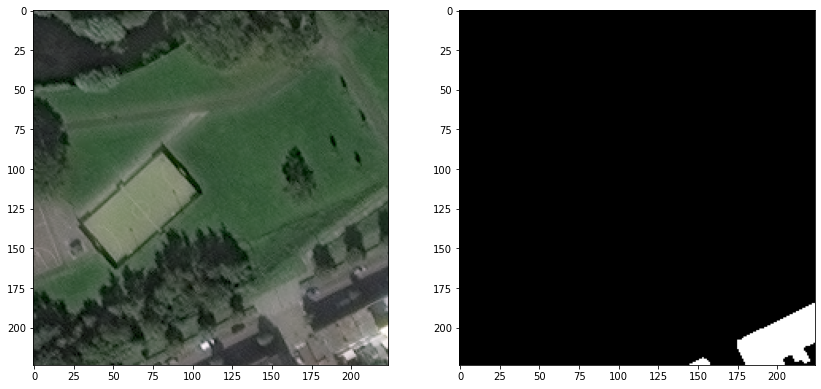

Index: 1191


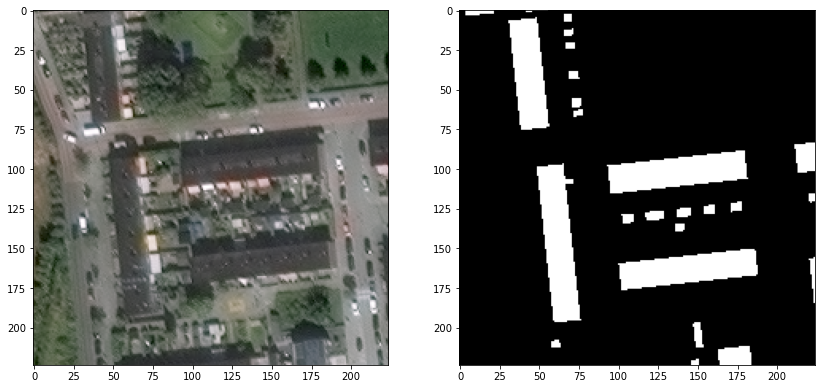

Index: 1532


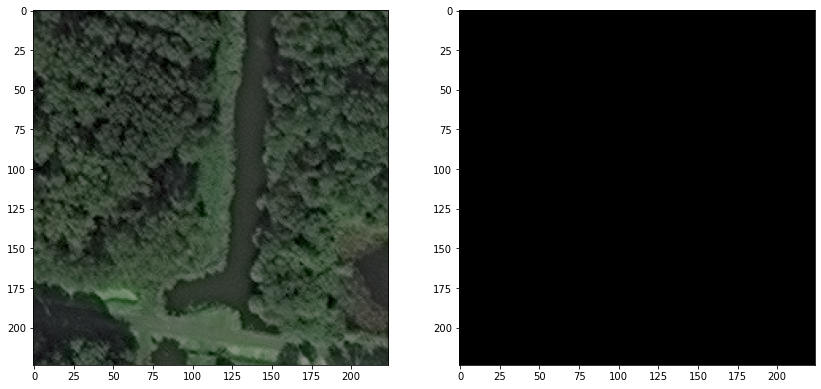

In [35]:
fnames_test_img = get_fnames(PATH_TEST_IMG)
fnames_test_mask = get_fnames(PATH_TEST_MASK)

for i in range(4):
    index = np.random.randint(0, len(fnames_test_img))
    sample_img = rebuild_npy(PATH_TEST_IMG/fnames_test_img[index])
    sample_mask = rebuild_npy(PATH_TEST_MASK/fnames_test_mask[index])
    
    sample_img = Image.fromarray(sample_img)
    sample_mask = Image.fromarray(sample_mask)
    plot_img_mask(sample_img, sample_mask, index)

# We've managed to make a train-test set that is about 5GB. Now what?
Now that we have our proper dataset, it is time to move on to our code proper. We can now start building neural networks to perform our key task - <b>image segmentation</b>